In [99]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [100]:
trainDF = pd.read_csv('train.csv')
testDF = pd.read_csv('test.csv')
concatDF = pd.concat([trainDF,testDF])
concatDF = concatDF.reset_index(drop=True)

print(concatDF.info())
concatDF.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB
None


,id,keyword,location,text,target
9554,6539,injury,NaN,CLEARED:incident with injury:I-495 inner loop...,NaN


In [101]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF:pd.DataFrame):
        self.target= DF['target'].values
        self.text = DF['text'].values
        self.id= DF['id'].values
        pass

    def __len__(self):
        return len(self.id)

    def __getitem__(self, idx):
        text = self.text[idx]
        target = self.target[idx]

        return (target, text)


trainSet = MyDataset(DF=concatDF[:len(trainDF)])
testSet = MyDataset(DF=concatDF[len(trainDF):])
trainSet[0]

(1.0, 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

In [102]:
split_train_, split_valid_ = torch.utils.data.dataset.random_split(
    trainSet, [0.8,0.2]
)

In [103]:
tokenizer = get_tokenizer("basic_english")

train_iter= iter(trainSet)

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
vocab(['here', 'is', 'an', 'example'])

[131, 14, 53, 3116]

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [105]:
# Hyperparameters
BATCH_SIZE = 64  # batch size for training

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor(vocab(tokenizer(_text)), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_dataloader = torch.utils.data.DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = torch.utils.data.DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = torch.utils.data.DataLoader(
    testSet, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

next(iter(train_dataloader))

/var/folders/p1/3vvm71l55lddcz4t_gf8bd1r0000gn/T/ipykernel_84737/2394242785.py:11: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_list = torch.tensor(label_list, dtype=torch.int64)


(tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
         0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]),
 tensor([9166,   47,  150,  ...,    6,    6,    6]),
 tensor([   0,   16,   42,   58,   71,   90,   98,  121,  141,  166,  187,  195,
          218,  236,  252,  261,  287,  307,  322,  339,  369,  388,  414,  427,
          446,  473,  497,  513,  542,  567,  588,  619,  646,  652,  669,  697,
          709,  728,  751,  758,  777,  801,  822,  830,  849,  879,  903,  934,
          945,  972,  997, 1011, 1028, 1038, 1064, 1069, 1092, 1115, 1131, 1160,
         1172, 1203, 1218, 1240]))

In [106]:
class TextClassificationModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = torch.nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = torch.nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [107]:
num_class = 2
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [108]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            total_acc, total_count = 0, 0


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for label, text, offsets in dataloader:
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

/var/folders/p1/3vvm71l55lddcz4t_gf8bd1r0000gn/T/ipykernel_84737/2394242785.py:11: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_list = torch.tensor(label_list, dtype=torch.int64)


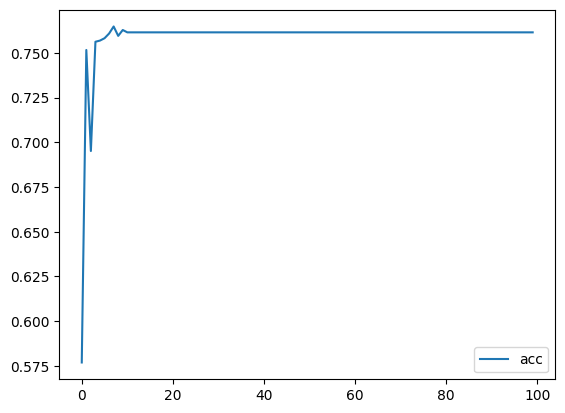

In [109]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

acc=[]
for epoch in range(100):
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    acc.append(accu_val)
plt.plot(acc,label='acc')
plt.legend()

In [110]:
plt.close()

In [115]:
ag_news_label = {0:'not', 1: "real"}

def predict(text):
    with torch.no_grad():
        text = torch.tensor(vocab(tokenizer(text)))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() 

ex_text_str = 'help me'

print("This is %s a disaster news" % ag_news_label[predict(ex_text_str)])

This is not a disaster news


In [403]:
# an EmbeddingBag module containing 10 tensors of size 3
embedding_sum = torch.nn.EmbeddingBag(10, 2)
embedding_sum.weight

Parameter containing:
tensor([[ 0.7644, -0.4108],
        [-1.2248, -0.1693],
        [ 2.0349, -0.1983],
        [-1.3923, -1.0001],
        [-0.3993,  0.0753],
        [-0.4518,  1.5984],
        [-1.0301,  1.6998],
        [-0.9426, -0.3739],
        [-1.8692,  0.9266],
        [-1.8792,  0.6143]], requires_grad=True)

In [405]:
# a batch of 2 samples of 4 indices each
input = torch.tensor([0,1,2,3,4,5,6,7,8,9], dtype=torch.long)
offsets = torch.tensor([0, 2], dtype=torch.long)
embedding_sum(input, offsets)

tensor([[-0.2302, -0.2901],
        [-0.7412,  0.4178]], grad_fn=<EmbeddingBagBackward0>)

In [361]:
# Example with padding_idx
embedding_sum = torch.nn.EmbeddingBag(10, 3, mode='sum', padding_idx=2)
input = torch.tensor([2, 2, 2, 2, 4, 3, 2, 9], dtype=torch.long)
offsets = torch.tensor([0, 4], dtype=torch.long)
embedding_sum(input, offsets)

tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.9222,  0.9806, -0.6375]], grad_fn=<EmbeddingBagBackward0>)

In [363]:
# An EmbeddingBag can be loaded from an Embedding like so
embedding = torch.nn.Embedding(10, 3, padding_idx=2)
embedding_sum = torch.nn.EmbeddingBag.from_pretrained(embedding.weight,
        padding_idx=embedding.padding_idx,
        mode='sum')